# The Transformer Architecture

The transformer architecture was introduced in 2017 by a team of researchers from Google Deep Mind, in a paper called [Attention is All you Need](https://arxiv.org/pdf/1706.03762) and achieved State Of the Art (SOTA) performance in translation tasks due to some key insights. Since then, it has achieved SOTA performance in a range of other tasks in Natural Language Processing (NLP), computer vision and others, and today it is the model behind all most advancement in deep learning and generative AI.

In the original paper, the authors implemented and Encoder-Decoder Transformer, whose architecture can be seen in Figure 1. In this code, we'll implement a Decoder-Only transformer, which has only the right side of the image below and only the first Multi-Head Attention. 

<figure>
    <img src="images/transformer.png" alt="Transformer" width="500"/>
    <figcaption>Fig. 1: Attention Is All You Need, Figure 1. The decoder-encoder transformer model.</figcaption>
</figure>

## The path of the data throughout the model
Our objective is, given an input sequence of token $X_{1:N}$, predict the next token $X_{N+1}$.

### Token embedding
Neural networks can only accept numerical values as input. Although token IDs are numbers in $\mathbb{Z}$, they cannot be fed into the network, because they are arbitrary numbers, and the model expects continuous values with some underling meaning as input. Instead, we'll create an embedding matrix $E \in \mathbb{R}^{vocab\_size \times d\_model}$, and each token $t_i$ will be mapped to a vector $x_i \in \mathbb{R}^{d\_model}$, resulting in matrix $X \in \mathbb{R}^{context\_size \times d\_model}$. This trick allows the model to learn the token representations by itself. Suppose for example that our vocabulary has the words *beautiful* and *stunning*. If the model can learn the representations, it can learn that these two have similar meaning, thus they should be close together in the embedding space. Finally, we provide positional information to the tokens by summing up the positional encoding into $X$.

### Decoder blocks
The decoder-only transformer is composed of $N$ identical blocks, each block having a self-attention and a feed forward sublayer. While the self-attention sublayer update the tokens' incorporating context into their representation, the feed forward sublayer is a simple network with two layers and a ReLU activation function in between, that computes each row independently. Between these two sublayers, there is a skip connection and an operation of batch normalization, which address vanishing and exploding gradients problem and speed up training.

### Output
After the last block, a linear layer is applied to each row of $X$, giving us an output $O \in \mathbb{R}^{d\_context \times vocab\_size}$, which are the logits for each token. In the training stage, we predict *all* tokens in the sequence at once (using masking and shifting positions), as a mean of parallelize training and improve sample efficiency. In the inference stage however, we only use the last row of $O$ to make our prediction.

# Coding

Let's dive into the implementation.

In [11]:
# To run on kaggle install the right version of seaborn with
# pip install --upgrade seaborn==0.13.2

In [12]:
import os
import requests
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device:", device)

Device: cuda


## Self-Attention

Before the transformer architecture was invented, most NLP tasks were done with recurrent neural networks. These models keep an internal state $h$, and at each timestep $t$, the model receives an input $x_t$, updates its internal state to $h_t$ and uses $x_t$ and $h_t$ to predict $y_t$. For natural language tasks, the model can keep a representation of the text up to timestep $t$ and then make predictions.

The self-attention mechanism was the breakthrough from the transformer paper that made it outperform traditional Recurrent Neural Networks (RNNs) for NLP tasks back then. This happened for two reasons:

1. In RNNs, input sequences in the training set need to be processed sequentially due to the recurrent behavior of the model. Transformers, on the other hand, use multi-head attention in combination with masking, which allows for massive parallelization.

2. RNNs update their internal state $h_t$ for each timestep as a function of $h_{t-1}$ and $x_t$, which leads to information from earlier tokens in the sequence progressively vanishing. Transformers introduced self-attention, which makes every token in the input to attend every previous token.

### Attention score

The self-attention mechanism has a few key insights. First, it uses a Query $Q \in \mathbb{R}^{d_{model} \times d_q}$ matrix, which can be thought as a 'question' matrix. Each row $q_i$ asks the question: who is important in this context to my meaning? This is answered by the Key $K \in \mathbb{R}^{d_{model} \times d_k}$ matrix. In the attention formula, we'll multiply $QK^T = S$, so each element $S_{ij} = Q_iK_j^T$ is a score that describes how much two tokens relate. The higher the score, the more token j is important to token i.

Next, we normalize each row using softmax and multiply by the Value $V \in \mathbb{R}^{d_{model} \times d_v}$ matrix, that is what tokens will update their values with. Since each row of the softmax has the weights from token i with every other token in the sequence and is normalized to 1, each output row will be the weighed sum of the rows of V, i.e., a weighted sum of the values of the tokens in the sequence. This leads to the formula $$softmax\left(QK^T\right)V$$

which has all the essential parts of the attention mechanism. One last detail emerges when we analyze how these values behave as $d_{model}$ grows. Suppose $Q$ and $K$ are iid with mean 0 and variance 1. Then


$$
\begin{aligned}
Q_iK_j^T &= \sum_{d=1}^{d_{model}}q_{id}k_{dj} \implies \\

Var(Q_iK_j^T) &= Var\left(\sum_{d=1}^{d_{model}}q_{id}k_{dj}\right) = d\_model

\end{aligned}
$$

Therefore, dividing the sum by $\sqrt{d_{model}}$ makes the variance 1 again and creates numerical stability by avoiding large values. This leads us to the final attention formula:

$$Attention(X) = softmax\left(\frac{QK^T}{\sqrt{d_{model}}}\right)V $$

The matrices $Q$, $K$ and $V$ come from multiplying the learnable weight matrices $W_q,\ W_k,\ and\ W_v$ by $X$:

$$\begin{aligned}
Q &= XW_q\\
K &= XW_k\\
V &= XW_v\\
\end{aligned}$$

Which explains the 'self' in the self-attention name: the attention is calculated using the input itself.

Lastly, to get back to our original dimensions, the output is multiplied by the output matrix $W_o \in \mathbb{R}^{{d_v} \times d_{model}}$.

In [13]:
def unmasked_attention_score(Q: torch.tensor, K: torch.tensor, V) -> torch.tensor:
    """ Compute the attention score between two sequences of vectors.

    Args:   
        Qs (torch.tensor): A tensor of shape (batch_size, context_size, d_q) containing the queries.
        Ks (torch.tensor): A tensor of shape (batch_size, context_size, d_k) containing the keys.
        mask (torch.tensor): A tensor of shape (batch_size, context_size, context_size) containing the mask to apply to the attention score
    """
    d_model = Q.shape[-2] # = d_q = d_k = d_v
    qk_matrix = Q @ torch.transpose(K, -1, -2) / d_model**.5

    return torch.softmax(qk_matrix, dim=-1) @ V

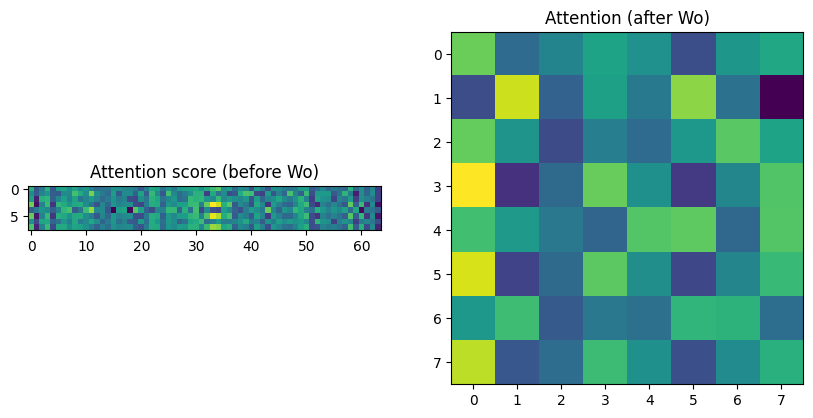

In [14]:
context_size = 8
d_q = d_k = d_v = 64

Qs = torch.normal(torch.zeros((context_size, d_q)), torch.ones((context_size, d_q)))
Ks = torch.normal(torch.zeros((context_size, d_k)), torch.ones((context_size, d_k)))
Vs = torch.normal(torch.zeros((context_size, d_v)), torch.ones((context_size, d_v)))
Wo = torch.normal(torch.zeros((d_v, context_size)), torch.ones((d_v, context_size)))

score = unmasked_attention_score(Qs, Ks, Vs)
att = score @ Wo

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(score.numpy())
ax[0].set_title("Attention score (before Wo)")

ax[1].imshow(att.numpy())
ax[1].set_title("Attention (after Wo)")

plt.show()

### Attention mask

The transformer is an autoregressive model, which means that it predicts one token at a time, and then it uses previous tokens to predict the next one, and so on, iteratively. In the training environment, the naive way to do this is to take an input sequence $X \in \mathbb{R}^N$, then use $X_{1:N-1}$  to predict $X_N$. This alone would be sample inefficient, so we can create a set of training examples from a single sequence of the form $\mathcal{T} = \{(X_{1:1}, X_2), (X_{1:2}, X_3), \dots, (X_{1:N-1}, X_N)\}$. Finally, instead of running each of these test cases one by one, we can run all at once if we can block information from flowing rightwards in the network, so that only past tokens are used to predict future tokens.

This is exactly where masking comes in: It sets the attention score before softmax to $-\inf$, so probabilities will be non-zero only for current and past tokens in the sequence. Therefore, at the final layer of the network, we'll have predictions for each token of the input, each prediction using only information from past tokens. Next we sum up the errors and use it all at once as our loss.

OBS 1: You may have noticed I said we only allow past *and current* token attention scores to be used for the prediction, so the network could cheat and just repeat the token itself for the prediction. To prevent this, we shift the input sequence one position to the right by adding a start token \<s\>. To make the sequences equal length and teach the network when to stop generating text, we also add an end token <\s> to the target:

<table>
  <tr>
    <td><b>Input</b></td>
    <td>&lt;s&gt;</td>
    <td>Hi</td>
    <td>,</td>
    <td>My</td>
    <td>Name</td>
    <td>Is</td>
    <td>Sam</td>
    <td>!</td>
  </tr>
  <tr>
    <td><b>Prediction</b></td>
    <td>Hi</td>
    <td>,</td>
    <td>My</td>
    <td>Name</td>
    <td>Is</td>
    <td>Sam</td>
    <td>!</td>
    <td>&lt;/s&gt;</td>
  </tr>
</table>


OBS 2: When I first learned about masking, I wondered why we would mask some tokens, if we're trying to predict the last one. I hope this explanation helped clarify that masking is used only during training: With masking, we can predict all tokens in the sequence at the same time, maximizing sample and compute efficiency. At inference time, however, masking is not necessary, since we only use the last position of the output.

In [15]:
def make_mask(mask: torch.tensor):
    """ Create a mask to hide the future tokens in a sequence.

    Args:
        mask (torch.tensor): A tensor of shape (batch_size, seq_len) containing 1s and 0s.
    """
    seq_len = mask.shape[-1]
    batch_size = mask.shape[-2]

    full_masks = torch.stack([torch.tril(torch.ones((seq_len, seq_len))) for _ in range(batch_size)]).long()
    full_masks = full_masks.to(mask.device) * mask.unsqueeze(1)
    
    return full_masks

Not all sequences in the training set will have the same size, but we will train in batches. For this end, we will pad pad the sequences to the same size. Since padding shouldn't be used to compute the attention score, sometimes we'll mask it.

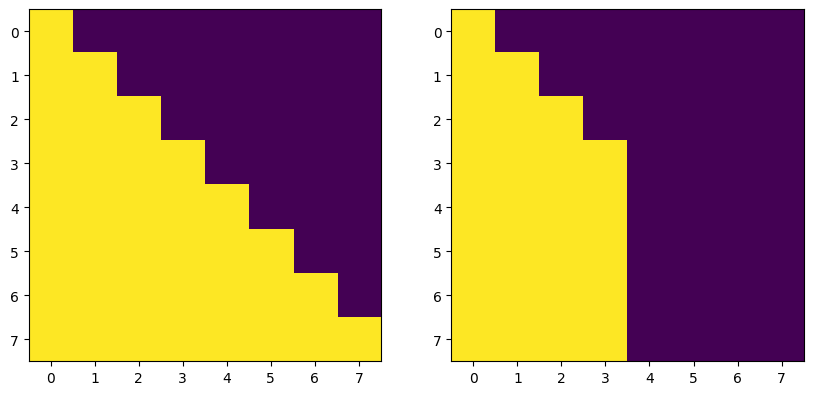

In [16]:
masks = make_mask(torch.tensor([[1,1,1,1,1,1,1,1], [1,1,1,1,0,0,0,0]]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(masks[0].cpu().numpy())
ax[1].imshow(masks[1].cpu().numpy())
plt.show()

### Multihead Attention

Instead of using only one attention head, the authors proposed using multiple heads, which allows the model to learn different attention patterns over a sentence. To that end, we'll now have independent $W_q \in \mathbb{R}^{d_{model} \times d_{q}}, W_k \in \mathbb{R}^{d_{model} \times d_{k}}, W_v \in \mathbb{R}^{d_{model} \times d_{v}}$ matrices for each head, with $d_q,\ d_k,\, d_v$ arbitrarily set to $\frac{d_{model}}{n_{heads}}$ in the paper as a mean to keep total compute constant.

The result is then concatenated, which gives $$MultiAtt(X) = concat(Att_1(X), Att_2(X), \dots, Att_{n_{heads}}(X))$$

The multihead attention allows for higher parallelization and lets the network learn multiple attention patterns from input sequences.

In [17]:
def multihead_attention(
        Qs: torch.tensor, Ks: torch.tensor, Vs: torch.tensor,
        *,
        mask: torch.tensor,
    ) -> torch.tensor:
    """ Compute the multi-head attention between two sequences of vectors.

    Args:
        Qs (torch.tensor): A tensor of shape (batch, n_heads, context_size, d_model/n_heads) containing the queries.
        Ks (torch.tensor): A tensor of shape (batch, n_heads, context_size, d_model/n_heads) containing the keys.
        Vs (torch.tensor): A tensor of shape (batch, n_heads, context_size, d_model/n_heads) containing the values.
        n_heads (int): The number of heads to use in the multi-head attention.
        mask (torch.tensor): A tensor of shape (batch, context_size) containing the mask to apply to the attention score
    """
    # Get the batch_size, number of heads and the context_size
    batch = Qs.shape[0]
    n_heads = Qs.shape[1]
    context_size = Qs.shape[2]

    # Resize mask to (batch, n_heads, context_size, context_size)
    mask = make_mask(mask)
    mask = mask.unsqueeze(1).repeat(1, n_heads, 1, 1)

    # Compute the attention score with shape (batch, n_heads, context_size, d_model)
    att = attention_score(Qs, Ks, Vs, mask)

    # Concatenate along the n_heads dimension
    att = att.permute(0, 2, 1, 3).reshape(batch, context_size, -1)

    return att

def attention_score(Qs: torch.tensor, Ks: torch.tensor, Vs: torch.tensor, mask: torch.tensor) -> torch.tensor:
    """ Compute the attention score between two sequences of vectors.

    Args:   
        Q (torch.tensor): A tensor of shape (batch_size, n_heads, context_size, d_q) containing the queries.
        K (torch.tensor): A tensor of shape (batch_size, n_heads, context_size, d_k) containing the keys.
        V (torch.tensor): A tensor of shape (batch_size, n_heads, context_size, d_v) containing the values.
        mask (torch.tensor): A tensor of shape (batch_size, n_heads, context_size, context_size) containing the mask to apply to the attention score
    """
    d_q = Qs.shape[-2] # = d_k = d_model/n_heads

    qk = Qs @ torch.transpose(Ks, -1, -2) / d_q**.5
    qk = torch.where(mask == 0, -1e9, qk)
    
    att = torch.softmax(qk, dim=-1) @ Vs
    
    return att

att.shape=torch.Size([1, 8, 64])


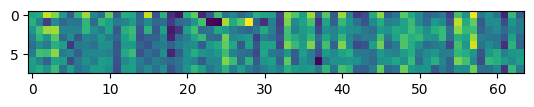

In [18]:
mask = torch.tensor([[1,1,1,1,1,1,0,0]])

Qs = torch.normal(torch.zeros((1, 2, 8, 32)), torch.ones((1, 2, 8, 32)))
Ks = torch.normal(torch.zeros((1, 2, 8, 32)), torch.ones((1, 2, 8, 32)))
Vs = torch.normal(torch.zeros((1, 2, 8, 32)), torch.ones((1, 2, 8, 32)))

att = multihead_attention(Qs, Ks, Vs, mask=mask)
print(f"{att.shape=}")

plt.imshow(att[0].numpy())
plt.show()

## Positional embedding

After the [tokenization](##Tokenization) and text embedding, we are left with a matrix $X \in \mathbb{R}^{n\_context \times d\_model}$, each row representing a token in the embedding space, which will be the input to our model. However, due to its nature, it can't know where each token is, which means equal tokens will be computed equal values throughout all the attention and dense layers, and will output equal probabilities. For instance, in the sentence "I love my new book my friend recommended me", the tokens 'my' will be the same, despite having distinct semantic meanings: the first 'my' refers to 'new book', and the second 'my' refers to 'friend'. For that reason, we add positional information to X thought a positional embedding matrix.

The positional encoding is simply a cosine and a sine function applied to different positions in the $X$ matrix, following the formula

$$ \begin{aligned}

PE_{(pos, 2i)}&=sin\left(\frac{pos}{10000^{2i / d_{model}}}\right) \\
PE_{(pos, 2i+1)}&=cos\left(\frac{pos}{10000^{2i / d_{model}}}\right)

\end{aligned}
$$

where $pos$ is the position in the sequence and $i$ is the dimension.

<details>

Let $X$ be our input matrix. Suppose $X_i = X_j$ and let $S$ be the right-most side of the attention equation, before multiplying the softmax score by V. Then $$S_i = softmax\left(\frac{Q_i K^T}{d_{model}} \right) = softmax\left(\frac{Q_j K^T}{d_{model}} \right) = S_j$$

where $S_i$ and $S_j$ are rows of $S$. After the attention head we'll have

$$Att_i = S_iV = S_jV = Attj$$

Since rows are computed independently in the dense layers, $$DNN(Att_i) = DNN(Att_j)$$

And we would end up with the same output for both tokens. It's fairly easy to check this by yourself: just comment the line that adds the positional embedding in the transformer class below, create an input sequence with repeated vectors, and check that the outputs will be the same for them.

</details>

In [19]:
def add_positional_emb(word_matrix: torch.tensor):
    """ Add positional embeddings to a word matrix.

    Args:
        word_matrix (torch.tensor): A tensor of shape (batch_size, context_size, d_model) containing the word vectors.
    """
    d_context = word_matrix.shape[-2]
    d_model = word_matrix.shape[-1]
    
    pos = torch.stack([torch.arange(d_context)] * d_model).T
    idx = torch.stack([torch.arange(d_model)] * d_context)
    
    pos_emb = torch.where(
        idx % 2 == 0, 
        torch.sin(pos/10_000**(2*idx/d_model)),
        torch.cos(pos/10_000**(2*idx/d_model))
    )
    
    pos_emb = pos_emb.to(word_matrix.device)
    
    return word_matrix + pos_emb

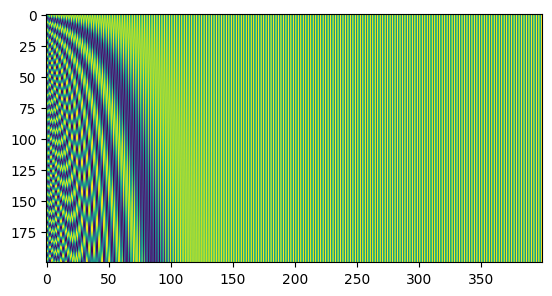

In [20]:
plt.imshow(add_positional_emb(torch.zeros((1, 200,400)).to(device)).cpu()[0].numpy())
plt.show()

## Decoder block

As described before, the decoder-only transformer is composed of several blocks of decoders. Each decoder receives as input $X$, creates the Q, K and V matrices using $W_q$, $W_k$ and $W_v$, applies the attention, brings $X$ back to $d\_model$ using $W_o$ and applies the feed forward token-wise. Between the sublayers are the skip connections (previous layer output + X in lines 60 and 63) and the batch normalization*.

\* I'm pretty sure the sum should be actually inside the batch norm, but I already trained the network this way and it seems to work, so I won't change because it would take too long to train it again.

In [21]:
class Decoder(nn.Module):
    
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.n_heads = n_heads
        
        ### Attention sublayer
        # Attention matrices with shape (d_model, d_model)
        Wqs = torch.normal(torch.zeros((d_model,d_model)), torch.ones((d_model,d_model)))
        Wks = torch.normal(torch.zeros((d_model,d_model)), torch.ones((d_model,d_model)))
        Wvs = torch.normal(torch.zeros((d_model,d_model)), torch.ones((d_model,d_model)))

        # Reshape matrices to (n_heads, d_model, d_model/n_heads)
        self.Wqs = nn.Parameter(Wqs.reshape(n_heads, d_model, d_model // n_heads))
        self.Wks = nn.Parameter(Wks.reshape(n_heads, d_model, d_model // n_heads))
        self.Wvs = nn.Parameter(Wvs.reshape(n_heads, d_model, d_model // n_heads))
        
        # Output matrix with shape (d_model, d_model)
        self.Wo = nn.Parameter(torch.normal(torch.zeros((d_model,d_model)), torch.ones((d_model,d_model))))


        ### Feed forward sublayer
        # Feed forward
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        
        ### LayerNorm
        # LayerNorm
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        
        # dropout
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, X: torch.tensor, mask: torch.tensor):
        """ Forward pass of the decoder.

        Args:
            X (torch.tensor): A tensor of shape (batch, context, d_model) containing the input.
            mask (torch.tensor): A tensor of shape (batch_size, context) containing the mask to apply to the attention score
        """
        # Add a dimension for the heads (batch, 1, context, d_model)
        X = X.unsqueeze(1)

        # Shapes after matmul are (batch, n_heads, context, d_model/n_heads)
        Qs = X @ self.Wqs
        Ks = X @ self.Wks
        Vs = X @ self.Wvs
        
        # output from multihead attention has shape (batch, context, d_model)
        attention = multihead_attention(Qs, Ks, Vs, mask=mask)

        attention = attention @ self.Wo

        # squeeze the n_head dimension from X and make the skip connection
        normalized_1 = self.dropout(self.layer_norm_1(attention)) + X.squeeze(1)

        feed_forward = self.ffn(normalized_1)
        normalized_2 = self.dropout(self.layer_norm_2(feed_forward)) + normalized_1

        return normalized_2

In [28]:
decoder = Decoder(d_model=8, n_heads=2, d_ff=64, dropout=0)

x = torch.normal(torch.zeros((1, 3, 8)), torch.ones((1, 3, 8)))
mask = torch.tensor([[1,1,1]])
target = decoder(x, mask=mask)
print(f"{x.shape=}")
print(f"{target.shape=}")

x.shape=torch.Size([1, 3, 8])
target.shape=torch.Size([1, 3, 8])


## Transformer

The transformer class just puts all we have seen until now together.

In [30]:
class Trasformer(nn.Module):
    
    def __init__(self, *,  blocks, vocab_size, d_model, n_heads, d_ff, dropout):
        super().__init__()
        
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
        
        self.decoders = nn.ModuleList()
        for _  in range(blocks):
            self.decoders.append(Decoder(d_model, n_heads, d_ff, dropout))
            
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, mask):
        """ Forward pass of the transformer.

        Args:
            x (torch.tensor): A tensor of shape (batch, context_size) containing the input.
            mask (torch.tensor): A tensor of shape (batch, context_size) containing the mask to apply to the attention
        """
        # After embedding, x has shape (batch, context_size, d_model)
        x = self.emb(x)
        x = add_positional_emb(x)
        
        # Go through the decoders. input and output shapes are (batch, context_size, d_model)
        for decoder in self.decoders:
            x = decoder(x, mask)

        # Linear layer
        logits = self.linear(x)

        # shape is (batch, context_size, vocab_size)
        return logits
        

In [16]:
transformer = Trasformer(blocks=2, vocab_size=10, d_model=8, n_heads=2, d_ff=64, dropout=0)

x = torch.randint(0, 10, (1, 3))
mask = torch.tensor([[1,1,1]])

target = transformer(x, mask=mask)
print(f"{target.shape=}")

target.shape=torch.Size([1, 3, 10])


## Loss

We'll use cross entropy as our loss. The label smoothing argument adds uncertainty to the model: the target classes will never have probability 1 (unless label smoothing is set to 0). This encourages the model to explore more labels. The ignore index argument add the possibility to ignore some class in the loss. We'll use it to ignore the paddings.

In [17]:
def cross_entropy_loss(logits: torch.tensor, target: torch.tensor, label_smoothing=0, ignore_index=-100):
    """ Compute the cross entropy loss between the logits and the target.

    Args:
        logits (torch.tensor): A tensor of shape (batch, context, vocab_size) containing the logits.
        target (torch.tensor): A tensor of shape (batch, context) containing the target.
        label_smoothing (float): The label smoothing factor.
        ignore_index (int): The index to ignore in the loss computation.
    """
    batch_size, context, vocab_size = logits.shape

    # Flatten the logits and target
    logits = logits.view(-1, vocab_size)
    target = target.view(-1)

    loss = F.cross_entropy(logits, target, ignore_index=ignore_index, label_smoothing=label_smoothing)

    return loss

# Dummy problem

As a dummy problem, we'll create sequences of numbers and mirror them. Then, we'll train the transformer to predict the complete sequence. Because of masking, it should only be able to guess the second half (when the first half of the sequence, with the tokens that will be mirrored, has already been seen), and therefore reach an accuracy just above 50% (it can still get some numbers right by chance in the first half). Note that in this dummy problem, we are not shifting the sequence to the left with the start and end tokens.

## Data

In [18]:
x = np.random.randint(0, 10, (10_000, 8))
x = torch.tensor(x).long()

idx_train = int(len(x) * .7)

train_data = x[:idx_train]
val_data = x[idx_train:]

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

print(f"Training observations: {len(train_data)}")
print(f"Validation observations: {len(val_data)}")
print()

print("x:", "".join((train_data[0]).numpy().astype(str)))
print("y:", "".join((train_data[0].flip(-1)).numpy().astype(str)))

Training observations: 7000
Validation observations: 3000

x: 53128682
y: 28682135


In [19]:
model = Trasformer(blocks=5, 
                   vocab_size=10, 
                   d_model=128, 
                   n_heads=1,
                   d_ff=128*4, 
                   dropout=.5)
model = model.to(device)

pred = model(train_data[0:1].to(device), mask=torch.ones((1, 8)).long().to(device))
print(f"{pred.shape=}")
print(f"Prediction: {''.join(pred.argmax(-1).cpu().numpy().astype(str)[0])}")

pred.shape=torch.Size([1, 8, 10])
Prediction: 63635806


## Training

In [20]:
model = Trasformer(blocks=2,
                   vocab_size=10, 
                   d_model=64,
                   n_heads=4,
                   d_ff=64*4, 
                   dropout=.3)
model = model.to(device)
print(f"# params: {sum(p.numel() for p in model.parameters())}")
print()

loss_func = cross_entropy_loss
opt = torch.optim.Adam(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer=opt
)

if os.path.exists("model.pth"):
    model.load_state_dict(torch.load("model.pth"))

else:
    epochs = 300
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        
        model.train()
        total_correct = 0
        total_loss = 0
        for x in train_dataloader:
            opt.zero_grad()

            y = x.flip((-1))

            x, y = x.to(device), y.to(device)
            pred = model(x, torch.ones_like(x).to(device))

            loss = loss_func(pred.cpu(), y.cpu())
            loss.backward()

            opt.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (pred.argmax(-1) == y).sum().item()
        
        train_loss.append(total_loss / len(train_data))
        train_acc.append(total_correct / (len(train_data) * 8))

        model.eval()
        total_correct = 0
        total_loss = 0
        with torch.no_grad():
            for x in val_dataloader:
                y = x.flip((-1))

                x, y = x.to(device), y.to(device)

                pred = model(x, torch.ones_like(x).to(device))

                loss = loss_func(pred.cpu(), y.cpu())

                total_loss += loss.item()
                total_correct += (pred.argmax(-1) == y).sum().item()

                
        val_loss.append(total_loss / len(val_data))
        val_acc.append(total_correct / (len(val_data) * 8))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}")
            print(f"Train loss: {train_loss[epoch]:.5f}; Train acc: {train_acc[epoch]*100:.2f}%")
            print(f"Val loss: {val_loss[epoch]:.5f}; Val acc: {val_acc[epoch]*100:.2f}%")
            print()

    torch.save(model.state_dict(), "model.pth")

# params: 100746

Epoch 0
Train loss: 0.08681; Train acc: 10.21%
Val loss: 0.07303; Val acc: 13.12%

Epoch 10
Train loss: 0.06692; Train acc: 20.01%
Val loss: 0.06433; Val acc: 21.77%

Epoch 20
Train loss: 0.06000; Train acc: 27.13%
Val loss: 0.05559; Val acc: 32.64%

Epoch 30
Train loss: 0.05589; Train acc: 32.72%
Val loss: 0.05135; Val acc: 39.18%

Epoch 40
Train loss: 0.05263; Train acc: 37.15%
Val loss: 0.04820; Val acc: 42.51%

Epoch 50
Train loss: 0.05002; Train acc: 40.17%
Val loss: 0.04567; Val acc: 45.38%

Epoch 60
Train loss: 0.04848; Train acc: 42.07%
Val loss: 0.04354; Val acc: 47.70%

Epoch 70
Train loss: 0.04544; Train acc: 45.76%
Val loss: 0.04080; Val acc: 50.40%

Epoch 80
Train loss: 0.04324; Train acc: 48.28%
Val loss: 0.03864; Val acc: 52.71%

Epoch 90
Train loss: 0.04153; Train acc: 50.26%
Val loss: 0.03820; Val acc: 53.12%

Epoch 100
Train loss: 0.04037; Train acc: 51.27%
Val loss: 0.03721; Val acc: 54.10%

Epoch 110
Train loss: 0.03952; Train acc: 52.33%
Val loss:

As expected, the model only achieves around 50% of accuracy, because it can never guess the first half of the sequence.

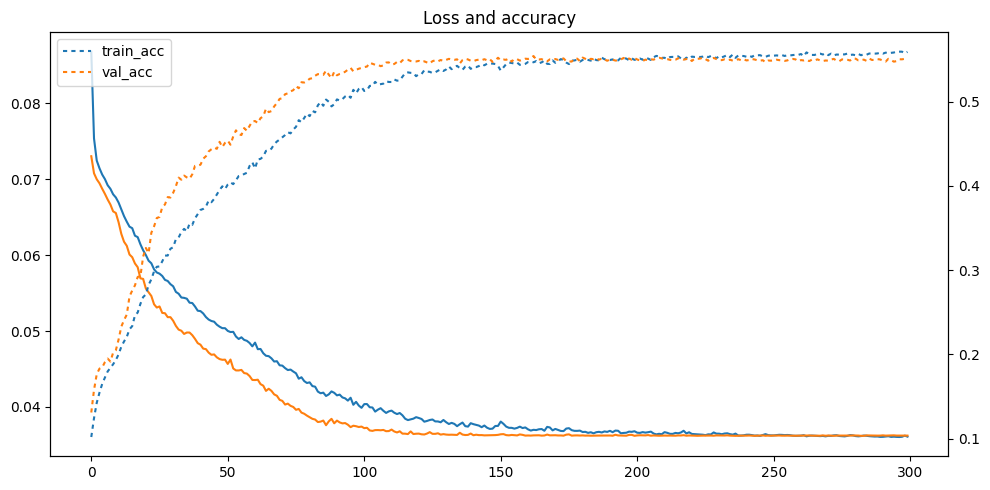

In [21]:
if not os.path.exists("loss_acc.png"):
    metricas = pd.DataFrame({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    fig = plt.figure(figsize=(10, 5))

    fig = sns.lineplot(data=metricas[["train_loss", "val_loss"]], dashes=False, legend=False)
    sns.lineplot(data=metricas[["train_acc", "val_acc"]], dashes=[(2, 2), (2, 2)], ax=fig.twinx())

    fig.set_title("Loss and accuracy")
    plt.tight_layout()

    plt.savefig("loss_acc.png")
    plt.show()

else:
    plt.figure(figsize=(10, 5))
    img = plt.imread("loss_acc.png")
    plt.axis('off')
    plt.imshow(img)

In [22]:
x = np.random.randint(0, 10, (1, 8))
print("x:\t", "".join(x[0].astype(str)[:4]) + ' ' + "".join(x[0].astype(str)[4:]))

x = torch.tensor(x).long().to(device)
pred = model(x.to(device), torch.ones_like(x).to(device))
pred = pred.argmax(-1).cpu().numpy().astype(str)[0]
print("pred:\t", "".join(pred[:4]) + ' ' + "".join(pred[4:]))

x:	 9982 8894
pred:	 2772 2899


# Shakespeare

Now, let's train our transformer on the complete work of shakespeare.

## Download and prepare data

In [23]:
url = "https://www.gutenberg.org/files/100/100-0.txt"
response = requests.get(url)
if response.status_code == 200:
    full_raw_test = response.content.decode("utf8")

In [24]:
vocab = {}
replace_tokens = {'‘': '\'', '’': '\'', '—': '-', '“': '"', '”': '"'}

for rplced_tkn, rplc_rkn in replace_tokens.items():
    full_raw_test = full_raw_test.replace(rplced_tkn, rplc_rkn)
    
full_raw_test = full_raw_test.replace('           ', '')

paragraphs = full_raw_test.split("\r\n\r\n")
paragraphs = [x for x in paragraphs if len(x) > 0]
paragraphs = paragraphs[1:-1]
paragraphs = [x for x in paragraphs if len(x) > 50]

print(f"Number of paragraphs: {len(paragraphs)}")
print()

samples = random.sample(paragraphs, 3)
for sample in samples:
    print(sample)
    print()

with open("paragraphs.txt", "w") as f:
    f.write("\n".join(paragraphs))

Number of paragraphs: 24420

KATHARINE.
_Sauf votre honneur_, me understand well.

He thence departs a heavy convertite;
She there remains a hopeless castaway.
He in his speed looks for the morning light;
She prays she never may behold the day.
"For day," quoth she, "night's scapes doth open lay,
    And my true eyes have never practised how
    To cloak offences with a cunning brow.

MOTHER.
Lucina lent not me her aid,
But took me in my throes,
That from me was Posthumus ripp'd,
Came crying 'mongst his foes,
A thing of pity.



## Tokenization

Neural networks can't understand strings, only numbers. To that end, we need to build a vocabulary and assign IDs to each token. A simple way to do this would be to make each word a token. A clever way is to start with all letters in the alphabet, and the gradually build our vocabulary from these letters, prioritizing the combinations that happen the most in the training data. This makes predictions easier for the model and avoid the need for Unknown \<unk> tokens.

In the code below, we train a tokenizer, pad and truncate sequences, and add special tokens to them. Note that the tokenizer already returns the attention mask for us.

In [25]:
VOCAB_SIZE = 5_000
CONTEXT_SIZE = 200


tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=["paragraphs.txt"], vocab_size=VOCAB_SIZE, min_frequency=2, special_tokens=[
    "<s>",
    "</s>",
    "<unk>",
    "<mask>",
    "<pad>"
])

### Pad the sequences to 200 tokens
truncation_strategy = {"max_length": CONTEXT_SIZE}
padding_strategy = {"length": CONTEXT_SIZE, "pad_token": "<pad>", "pad_id": tokenizer.token_to_id("<pad>")}

tokenizer.enable_truncation(**truncation_strategy)
tokenizer.enable_padding(**padding_strategy)

### Add the start and end tokens to each sequence
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)

encoding = tokenizer.encode("Hi my friend")
print(f"Tokens: {encoding.tokens[:10]}")
print(f"Ids: {encoding.ids[:10]}")
print(f"Mask: {encoding.attention_mask[:10]}")




Tokens: ['<s>', 'H', 'i', 'Ġmy', 'Ġfriend', '</s>', '<pad>', '<pad>', '<pad>', '<pad>']
Ids: [0, 44, 77, 317, 686, 1, 4, 4, 4, 4]
Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [26]:
encoded_paragraphs = tokenizer.encode_batch(paragraphs)
encoded_paragraphs = [(x.ids, x.attention_mask) for x in encoded_paragraphs]

train_size = .90
val_size = .10

torch.manual_seed(0)
idx = torch.randperm(len(encoded_paragraphs))

idx_train = int(len(encoded_paragraphs) * train_size)
idx_val = int(len(encoded_paragraphs) * val_size)

train_data = torch.tensor([encoded_paragraphs[i] for i in idx[:idx_train]]).to(device)
val_data = torch.tensor([encoded_paragraphs[i] for i in idx[idx_train:]]).to(device)

## Train and val

In [27]:
class ShakespeareDataset(Dataset):
    def __init__(self, dataset):
        """ Dataset for the Shakespeare dataset.

        Args:
            dataset (torch.tensor): A tensor of shape (n_observations, 2, seq_len) containing the input and mask.
        """
        self.x = dataset[:, 0, :-1]
        self.mask = dataset[:, 1, :-1]
        self.y = dataset[:, 0, 1:]
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.mask[idx]

In [28]:
train_dataset = ShakespeareDataset(train_data)
val_dataset = ShakespeareDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training

In [29]:
def train_an_epoch(model, train, val, opt, scheduler, loss_func):
    train_loss = 0
    val_loss = 0
    
    model.train()
    for x, y, mask in train:
        opt.zero_grad()
        out = model(x, mask)
        
        loss = loss_func(out, y)
        loss.backward()
        
        opt.step()
        scheduler.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train.dataset)
    
    
    model.eval()
    with torch.no_grad():
        for x, y, mask in val:
            out = model(x, mask)

            loss = loss_func(out, y)
            val_loss += loss.item()

    val_loss = val_loss / len(val.dataset)
    
    # print an example
    x, y, mask = val_dataset[torch.randint(0, len(val_dataset), (1,)).item()]
    out = model(x.unsqueeze(0), mask.unsqueeze(0))

    print(f"Input: {tokenizer.decode(x.tolist())[:30]}")
    print(f"Prediction: {tokenizer.decode(torch.argmax(out, -1)[0].tolist())[:30]}")
        
    return train_loss, val_loss

In [31]:
model = Trasformer(blocks=6,
                   vocab_size=VOCAB_SIZE, 
                   d_model=512, 
                   n_heads=8, 
                   d_ff=512 * 4, 
                   dropout=.2).to(device)
print(f"# params: {sum(p.numel() for p in model.parameters())}")

loss = lambda pred, target: cross_entropy_loss(pred, target, label_smoothing=.1, ignore_index=tokenizer.token_to_id("<pad>"))
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer=opt
)

epochs = 80
print(f"Total steps: {epochs * len(train_dataloader)}")


train_loss, val_loss = [], []
for epoch in range(epochs):
    tl, vl = train_an_epoch(model, train_dataloader, val_dataloader, opt, scheduler, loss)
    train_loss.append(tl)
    val_loss.append(vl)

    print(f"Epoch {epoch}, Train loss: {tl:.4f}, Val loss: {vl:.4f}")
    
    if vl == min(val_loss):
        torch.save(model.state_dict(), "/kaggle/working/model_shakespeare")

# params: 24027016
Total steps: 27520
Input: TYBALT.
Thou wretched boy, th
Prediction: KING....
I,,, I I, the,,,
I,
Epoch 0, Train loss: 0.1105, Val loss: 0.1930
Input: This picture she advisedly per
Prediction: KING......,,
I, the of King,,
Epoch 1, Train loss: 0.0984, Val loss: 0.1862
Input: QUEEN MARGARET.
Why, so I did
Prediction: KING MARGARET.
 th
Epoch 2, Train loss: 0.0951, Val loss: 0.1830
Input: PANTINO.
Lance, away, away! A
Prediction: KINGOLI...
I,, I, I, room,,,.
Epoch 3, Train loss: 0.0933, Val loss: 0.1806
Input:  Enter Gloucester, Bedford, Ex
 
Epoch 4, Train loss: 0.0918, Val loss: 0.1793
Input: HOTSPUR.
Sick now? Droop now?
Prediction: KING.
Iignior,,,,,,,,,,
I Kin
Epoch 5, Train loss: 0.0906, Val loss: 0.1772
Input: DESDEMONA.
[_Singing._]
    
Prediction: KING.
IAsideignior,, I   ,, K
Epoch 6, Train loss: 0.0896, Val loss: 0.1757
Input: ABBOT.
My lord,
Before I fre
Prediction: KINGIANT
I lord, sir
I,'ll,, 
Epoch 7, Train loss: 0.0887, Val loss: 0.1747
Input: MARIA.


Load back the best model

In [32]:
model.load_state_dict(torch.load("/kaggle/working/model_shakespeare"))

# Results

The networked was trained for about 1h30min

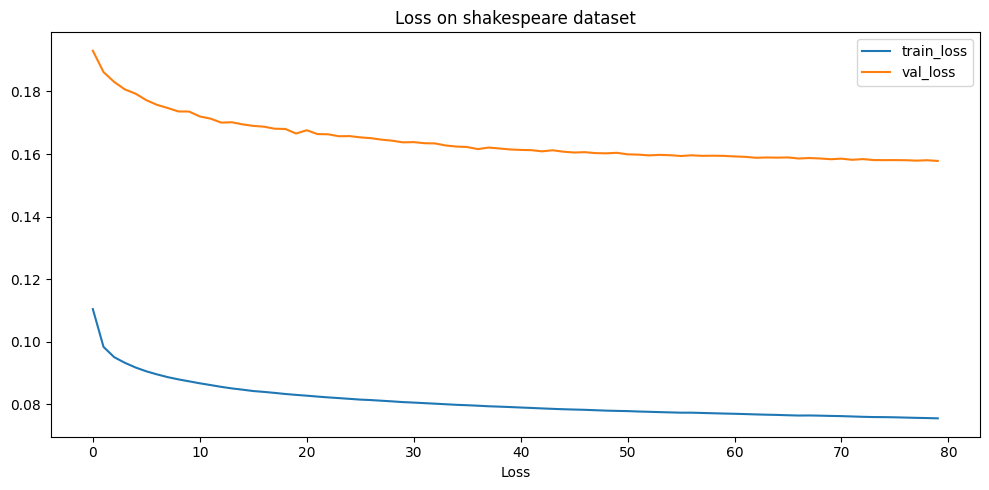

In [33]:
metricas = pd.DataFrame({
    "train_loss": train_loss,
    "val_loss": val_loss,
})

fig = plt.figure(figsize=(10, 5))

fig = sns.lineplot(data=metricas[["train_loss", "val_loss"]], dashes=False)

fig.set_title("Loss on shakespeare dataset")
fig.set_xlabel("Epoch")
fig.set_xlabel("Loss")


plt.tight_layout()

plt.show()

In [34]:
def complete(model, tokenizer, text, lenght):
    tokenizer.no_padding()
    tokenizer.no_truncation()

    tokens = tokenizer.encode(text)
    ids = tokens.ids

    ids = torch.tensor([ids]).to(device)
    mask = torch.ones_like(ids)

    with torch.no_grad():
        l = 0
        pred_id = None
        while pred_id != tokenizer.token_to_id("</s>") and l < lenght:
            pred = model(ids, mask)

            pred_id = pred[0, -1].argmax().item()
        
            ids = torch.cat([ids, torch.tensor([[pred_id]]).to(device)], dim=-1)
            mask = torch.ones_like(ids)

            l += 1

    tokenizer.enable_truncation(**truncation_strategy)
    tokenizer.enable_padding(**padding_strategy)

    return tokenizer.decode(ids[0].cpu().numpy())
    

In [35]:
print(complete(model, tokenizer, "Oh, god", 50))

Oh, god.
I'll be so much as I'll be gone,
And I'll be a man.


In [36]:
print(complete(model, tokenizer, "The love of my life\n", 50))

The love of my life
,
And I have been a man,
And I am surety thousand ducats,
And I have been a man,
And I am surety thousand ducats,
And I have a man,
And


# Questions from the curricumum

**What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?)**

**A:** First of all, RNNs process one token at a time, both for input and for output sequences, because each prediction depends on the previous ones, while transformers are highly parallelizable with their multi-headed attention mechanism, which lets the model compute many attention blocks in at the same time. Besides that, transformers use the self-attention, which calculates attetion scores for each token based on all other tokens at the same time. In RNNs, the attention is computed using the internal hidden state, which is a single vector that is updated in each prediction step. This makes tokens to be "forgotten" some steps ahead.

**Attention is defined as, $Attention(Q,K,V) = softmax\left(QK^T/\sqrt{(d_k)}\right)V$. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?**

**A**: To keep computational cost constant, the authors use $Q \in R^{context\_size \times d\_q}$ (same for K and V), with $d\_q = d\_k = d\_v = d\_model / n\_heads$. This way, $QK^T \in R^{context\_size \times context\_size}$, $softmax\left(QK^T/\sqrt{(d_k)}\right)V \in R^{context\_size \times d\_v}$, and after concatenation of all heades, $concat(attentions) \in R^{context\_size \times d\_model}$, which makes the same dimention of output for the entire block. It is like that so that query and key matrices compute scores, or how much each token is related to other tokens, and value matrix is the "value" of the tokens. So, after attention block, each token embedding is updated to be the weighted sum (softmax normalizes rows to 1) of all tokens, incorporating context to it.

**Are the dense layers different at each multi-head attention block? Why or why not?**

**A**: They have the same architecture, but they don't need to. The only restriction is that their input and their output must have all the same dimention, d_model, to fit in the output and input of attention layers.

**Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?**

**A**: Skip connections in deep neural networks are used to address the vanishing and exploding gradient problems. In a deep neural network, in the first stages of training, each layer will have random weights and will add a small amount of noise to the input and then pass it on to the next layer. If the network is too deep, later layers will only receive noise as input and will learn slowly. Furthermore, in backpropagation, the gradients will be less representative of the error for earlier layers. Skip connections create small blocks of layers in the network, shortening the path from later layers to the input, and from the error gradient to earlier layers, which significantly speeds up the training.